In [ ]:
# https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

# word embeddings models
# https://medium.com/nlplanet/two-minutes-nlp-11-word-embeddings-models-you-should-know-a0581763b9a9

# transformers models
# https://huggingface.co/models

+ 목표
  + 제품별 리뷰에 대해, 분류가 유의미한가?
  + 제품별 리뷰 분류는 차이가 있는가?
  + 어떤 모형이 한글리뷰를 잘 분리해 내는가?

+ 자료 : 네이버 리뷰(제품별로 각각 진행)

+ 모델링 시, 주요 적용 방법
  + 토큰화 : Okt
  + 임베딩 : transfomer 기반
  + 차원축소 : UMAP
  + 클러스터링 : DBSCAN



In [1]:
# !pip install bertopic -qqq
# !pip install bertopic[visualization] -qqq
!pip install konlpy -qqq
!pip install sentence-transformers -qqq
!pip install umap-learn -qqq
!pip install hdbscan -qqq

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 44.7 MB/s 
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 12.2 MB/s 
     |████████████████████████████████| 1.2 MB 33.7 MB/s 
     |████████████████████████████████| 77 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 26.8 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 6.6 MB 34.3 MB/s 
     |████████████████████████████████| 88 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
     |████████████████████████████████| 5.2 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# !pip install mecab-python3
# !apt-get update
# !apt-get install g++ openjdk-8-jdk python-dev python3-dev
# !pip3 install JPype1-py3
# !pip3 install konlpy
# !JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

### 1.Import

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from konlpy.tag import Okt

import pandas as pd

import numpy as np
import itertools
import pandas as pd

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import umap
import hdbscan
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


### 2.Data read

In [10]:
df = pd.read_excel('./20220421_soymilk_review_data1.xlsx', 0)
df = df.sample(frac=1) 
# df= df.dropna().reset_index

doc = df.token.dropna()
doc = list(doc)

In [ ]:
df.product_nm.unique()

array(['어메이징 오트 [ 오리지널 ] [ 190ml ]'], dtype=object)

In [3]:
df.tail(1)

In [ ]:
df.GROUP2.unique()

array(['오트음료 대체', '(미분류)', '배송', '맛(미각)', '우유 대체', '제품포장', '식사대용', '유통기한',
       '아몬드유 대체', '판촉', '두유 대체', '카페 음용', '환경(종이빨대 등)', '맛(촉각/후각)'],
      dtype=object)

In [ ]:
doc[-10:]

['배송 도 빠르다 포장 상태 굿  맛 부드럽다 좋다 ',
 '언제 나 믿다 먹다 매일 두유  배송 도 빠르다',
 '늘 먹다 에요 당 이 추 가인 된거 라 건강 생각 해서 자다 있다 어요 ',
 '두유 를 자다 못 먹다 이건 돼다',
 '마싯다 어요  오트밀크 도 매일 이 젤 담 백 하고 곡물 특 유의 기름 쩐맛 안나 서 좋다',
 '늘 재구매 하다 제품 이다 ',
 '달 지 않다 들다 하고 맛있다 ',
 '배고프다 때 먹다 포만 감다 크다 고참 좋다',
 '늘 쟁 여 먹다 두 유입 니 다  달 지 않다 좋다',
 '선물 드리다 많이 달 지 않다 아주 딱 마시기 좋다 하다 ']

### 3. 토픽 분류

In [5]:
from sentence_transformers import SentenceTransformer
# model_list = [
#               'albert-base-v2',
#               'distilbert-base-nli-mean-tokens',
#               'roberta-base-nli-stsb-mean-tokens',
#               'distiluse-base-multilingual-cased-v2',
#               'xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
#               ]

model_list = [
              'distilbert-base-nli-stsb-mean-tokens',
              'msmarco-distilbert-dot-v5',
              'paraphrase-albert-small-v2',
              'distilbert-multilingual-nli-stsb-quora-ranking',
              'quora-distilbert-multilingual',
              'distilbert-base-nli-stsb-quora-ranking',
              'paraphrase-albert-base-v2',

              'paraphrase-multilingual-MiniLM-L12-v2',
              'distiluse-base-multilingual-cased-v2',
              'distiluse-base-multilingual-cased',
              'distilbert-multilingual-nli-stsb-quora-ranking',
              'clip-ViT-B-32-multilingual-v1',
              'quora-distilbert-multilingual',
              'xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
              ]


for model_ in model_list:
    model = SentenceTransformer(model_)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/589 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/447 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

#### A. 주요 결과 시각화

In [16]:
model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking')
embeddings = model.encode(doc, show_progress_bar=True)

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

In [38]:
from sklearn.manifold import TSNE

umap_embeddings = umap.UMAP(n_neighbors=15, n_components=15, metric='cosine').fit_transform(embeddings)


ValueError: ignored

In [40]:
tsen_embeddings = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

In [41]:
# 클러스터링
cluster1 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)
cluster2 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(tsen_embeddings)


In [42]:
umap_embeddings = umap.UMAP(n_components=2, n_neighbors=15, metric='cosine').fit_transform(embeddings)
# tsen_embeddings = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

In [43]:
umap_embeddings[:3], tsen_embeddings[:3]

(array([[17.638102 ,  5.550958 ],
        [ 7.071596 ,  7.3175583],
        [ 8.449046 ,  6.4617386]], dtype=float32),
 array([[-27.78508 ,  38.744938],
        [ 31.033705,  22.27247 ],
        [ 23.828468,   5.290626]], dtype=float32))

In [44]:
# 결과 정리
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster1.labels_
result['REVIEW'] = doc
# result['MODEL'] = model_name

result2 = pd.DataFrame(tsen_embeddings, columns=['x', 'y'])
result2['labels'] = cluster2.labels_
result2['REVIEW'] = doc
# result2['MODEL'] = model_name

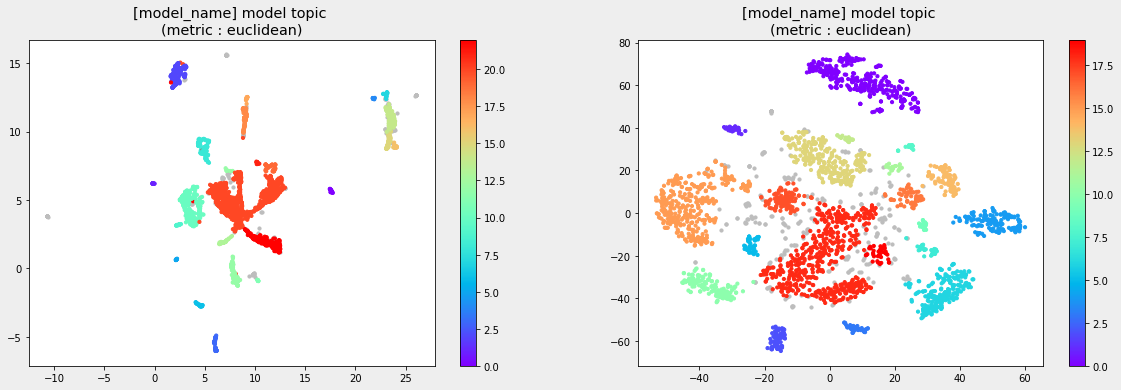

In [45]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')

plt.subplot(1,2,1)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='rainbow')
plt.title('[{}] model topic \n(metric : euclidean)'.format('model_name'),fontsize='x-large')
plt.colorbar()

plt.subplot(1,2,2)
outliers = result2.loc[result2.labels == -1, :]
clustered = result2.loc[result2.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='rainbow')
plt.title('[{}] model topic \n(metric : euclidean)'.format('model_name'),fontsize='x-large')
plt.colorbar()
plt.show()

In [46]:
excel_name ='review_data_sort_topic.xlsx'
writer = pd.ExcelWriter(excel_name)
result.to_excel(writer, 'Sheet1')
result2.to_excel(writer, 'Sheet2')
writer.save()

In [12]:
def topic_modeling(text_list, model_name):
    # 임베딩
    model = SentenceTransformer(model_name)
    embeddings = model.encode(text_list, show_progress_bar=True)

    # 차원축소
    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)
    pca_embeddings = PCA(n_components=15, svd_solver='full').fit_transform(embeddings)
    
    # 클러스터링
    cluster1 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)
    cluster2 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(pca_embeddings)

    # 결과 정리
    result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
    result['labels'] = cluster1.labels_
    result['REVIEW'] = text_list
    result['MODEL'] = model_name

    result2 = pd.DataFrame(pca_embeddings, columns=['x', 'y'])
    result2['labels'] = cluster2.labels_
    result2['REVIEW'] = text_list
    result2['MODEL'] = model_name

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')

    plt.subplot(1,2,1)
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : euclidean)'.format(model_name),fontsize='x-large')
    plt.colorbar()

    plt.subplot(1,2,2)
    outliers = result2.loc[result2.labels == -1, :]
    clustered = result2.loc[result2.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : euclidean)'.format(model_name),fontsize='x-large')
    plt.colorbar()
    plt.show()

    return result

In [14]:
Topic_Model_2 = topic_modeling(doc, 'distilbert-base-nli-stsb-quora-ranking')

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
Topic_Model_3 = topic_modeling(doc, 'distiluse-base-multilingual-cased-v2')

In [6]:
from sentence_transformers import SentenceTransformer

model_list = [
              # 'distilbert-base-nli-stsb-mean-tokens',
              'msmarco-distilbert-dot-v5',
              # 'paraphrase-albert-small-v2',
              # 'distilbert-multilingual-nli-stsb-quora-ranking',
              # 'quora-distilbert-multilingual',
              'distilbert-base-nli-stsb-quora-ranking',

              'paraphrase-multilingual-MiniLM-L12-v2',
              'distiluse-base-multilingual-cased-v2',
              'distilbert-multilingual-nli-stsb-quora-ranking',
              'clip-ViT-B-32-multilingual-v1',
              # 'quora-distilbert-multilingual',
              'xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
              ]

print('대상제품 : {} '.format(df.product_nm.unique()[0]))

for model_ in model_list:
    model = SentenceTransformer(model_)
    embeddings = model.encode(doc, show_progress_bar=True)

    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

    cluster1 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)
    cluster2 = hdbscan.HDBSCAN(min_cluster_size=12, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels1'] = cluster1.labels_
    result['labels2'] = cluster2.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')

    plt.subplot(1,2,1)
    outliers = result.loc[result.labels1 == -1, :]
    clustered = result.loc[result.labels1 != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels1, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : euclidean, )'.format(model_),fontsize='x-large')
    plt.colorbar()

    plt.subplot(1,2,2)
    outliers2 = result.loc[result.labels2 == -1, :]
    clustered2 = result.loc[result.labels2 != -1, :]
    plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=10)
    plt.scatter(clustered2.x, clustered2.y, c=clustered2.labels2, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : manhattan)'.format(model_),fontsize='x-large')
    plt.colorbar()
    plt.show()

AttributeError: ignored

대상제품 : 멸균 매일두유 [ 99.89 ] [ 190ml ] 


Batches:   0%|          | 0/135 [00:00<?, ?it/s]

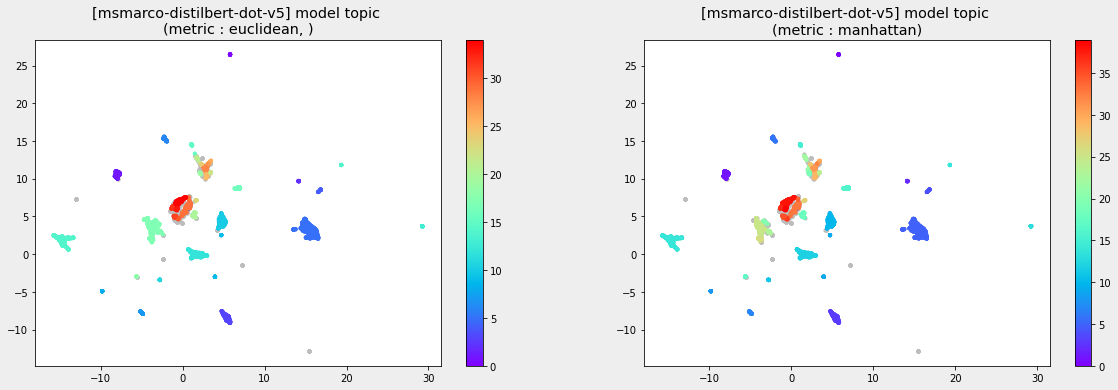

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

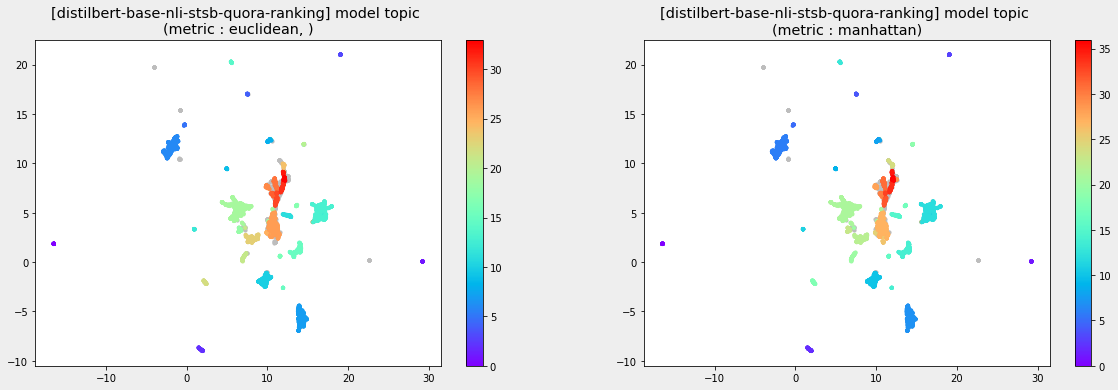

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

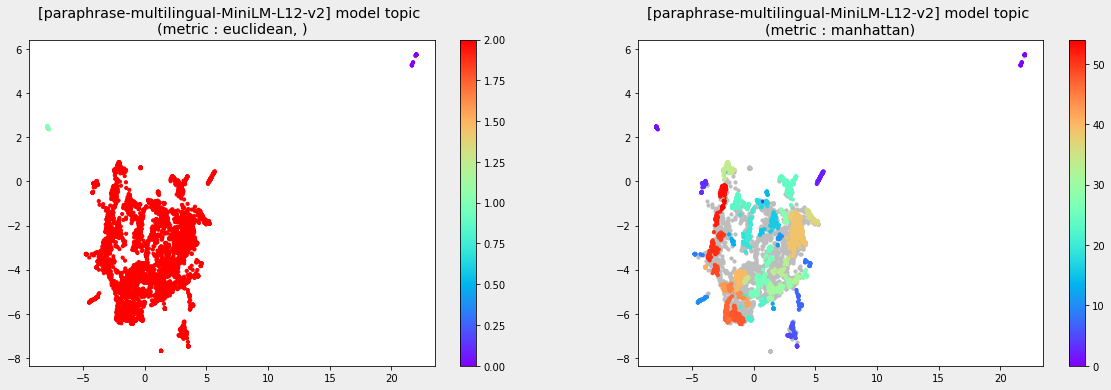

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

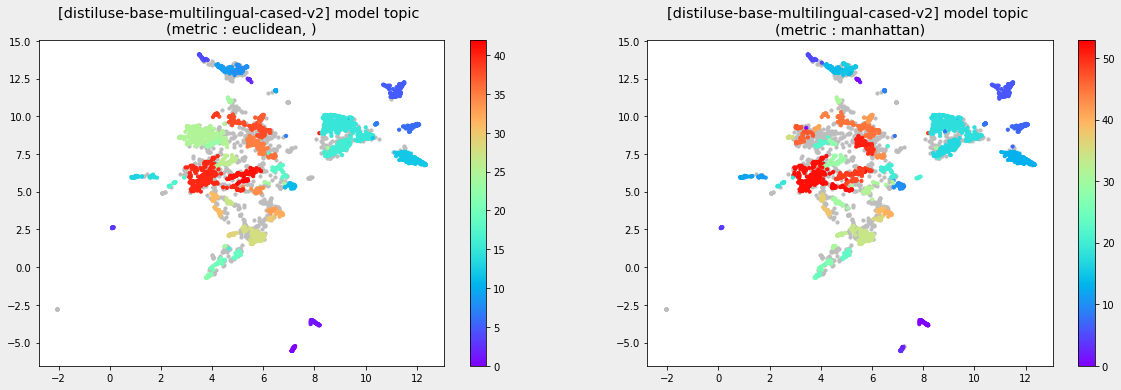

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

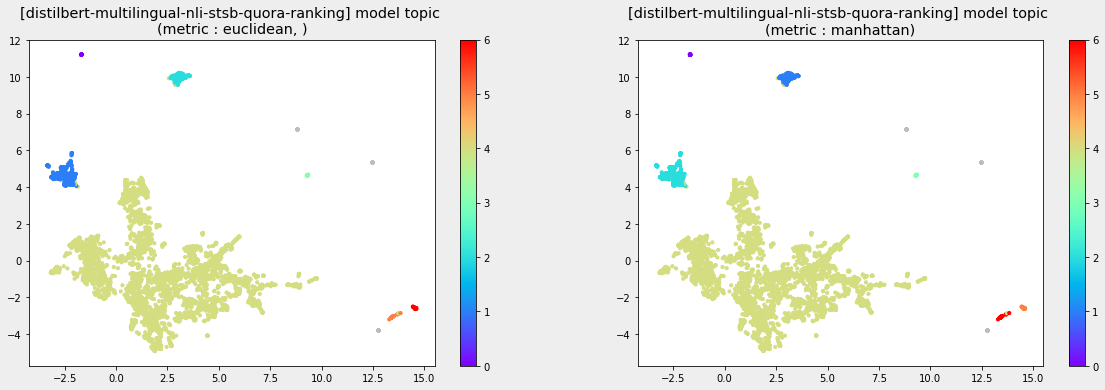

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

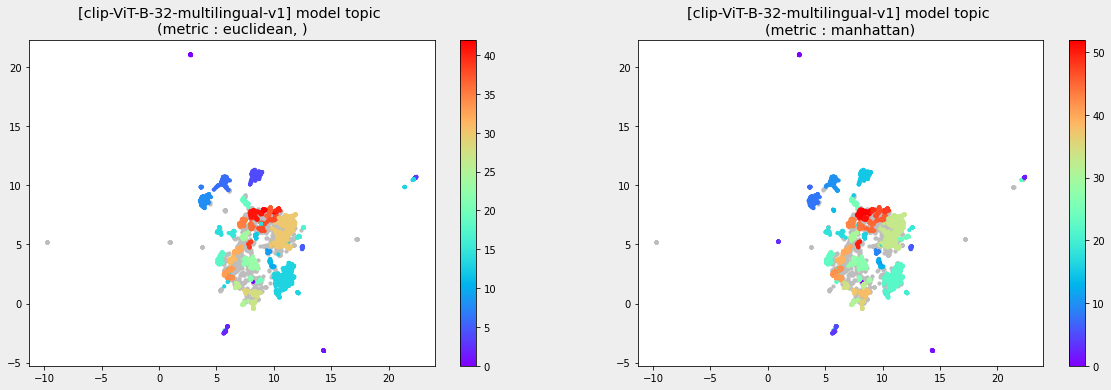

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

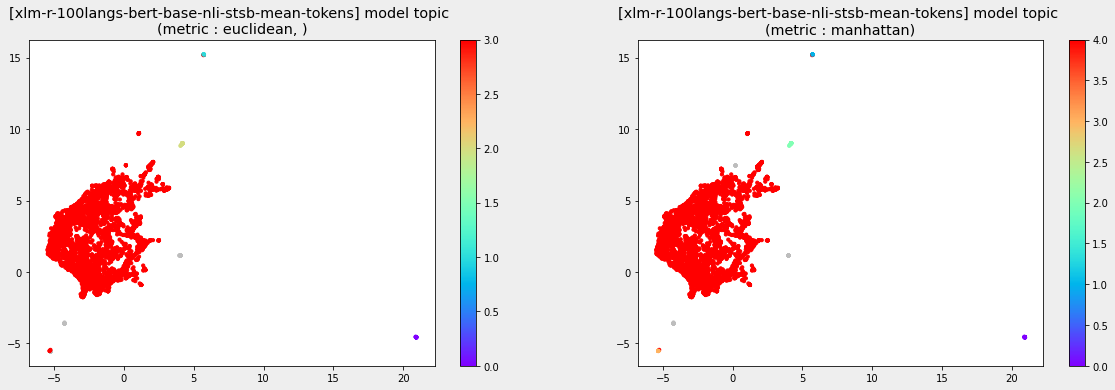

In [ ]:
from sentence_transformers import SentenceTransformer

model_list = [
              # 'distilbert-base-nli-stsb-mean-tokens',
              'msmarco-distilbert-dot-v5',
              # 'paraphrase-albert-small-v2',
              # 'distilbert-multilingual-nli-stsb-quora-ranking',
              # 'quora-distilbert-multilingual',
              'distilbert-base-nli-stsb-quora-ranking',

              'paraphrase-multilingual-MiniLM-L12-v2',
              'distiluse-base-multilingual-cased-v2',
              'distilbert-multilingual-nli-stsb-quora-ranking',
              'clip-ViT-B-32-multilingual-v1',
              # 'quora-distilbert-multilingual',
              'xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
              ]

print('대상제품 : {} '.format(df.product_nm.unique()[0]))

for model_ in model_list:
    model = SentenceTransformer(model_)
    embeddings = model.encode(doc, show_progress_bar=True)

    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

    cluster1 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)
    cluster2 = hdbscan.HDBSCAN(min_cluster_size=12, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels1'] = cluster1.labels_
    result['labels2'] = cluster2.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')

    plt.subplot(1,2,1)
    outliers = result.loc[result.labels1 == -1, :]
    clustered = result.loc[result.labels1 != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels1, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : euclidean, )'.format(model_),fontsize='x-large')
    plt.colorbar()

    plt.subplot(1,2,2)
    outliers2 = result.loc[result.labels2 == -1, :]
    clustered2 = result.loc[result.labels2 != -1, :]
    plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=10)
    plt.scatter(clustered2.x, clustered2.y, c=clustered2.labels2, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : manhattan)'.format(model_),fontsize='x-large')
    plt.colorbar()
    plt.show()

대상제품 : 어메이징 오트 [ 오리지널 ] [ 190ml ] 


Batches:   0%|          | 0/284 [00:00<?, ?it/s]

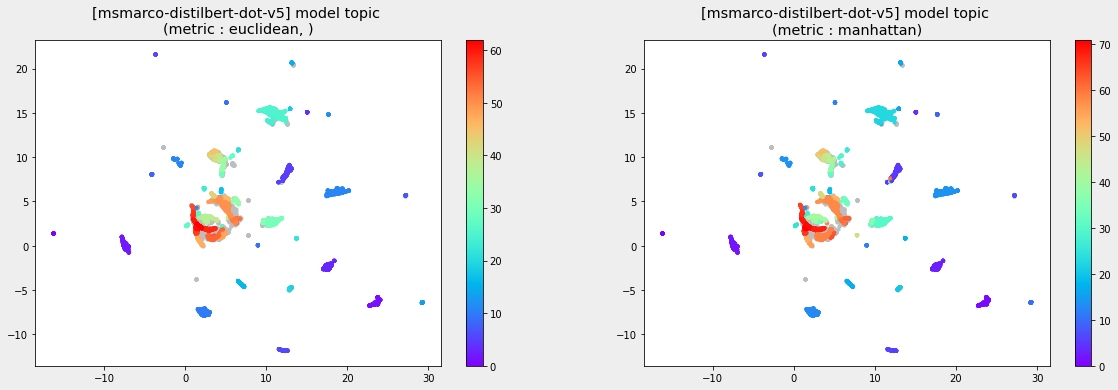

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

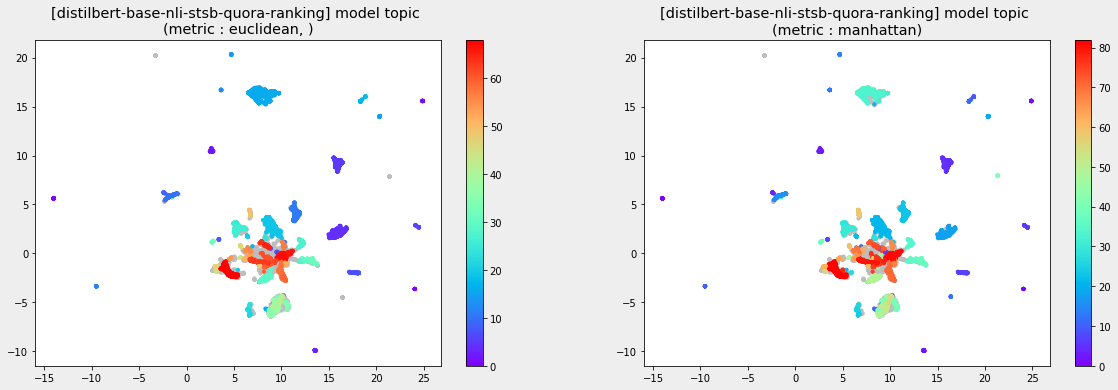

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

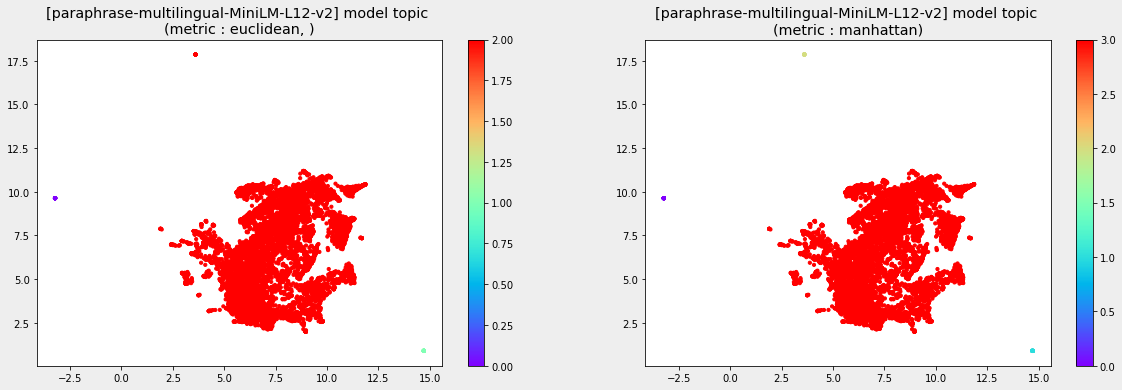

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

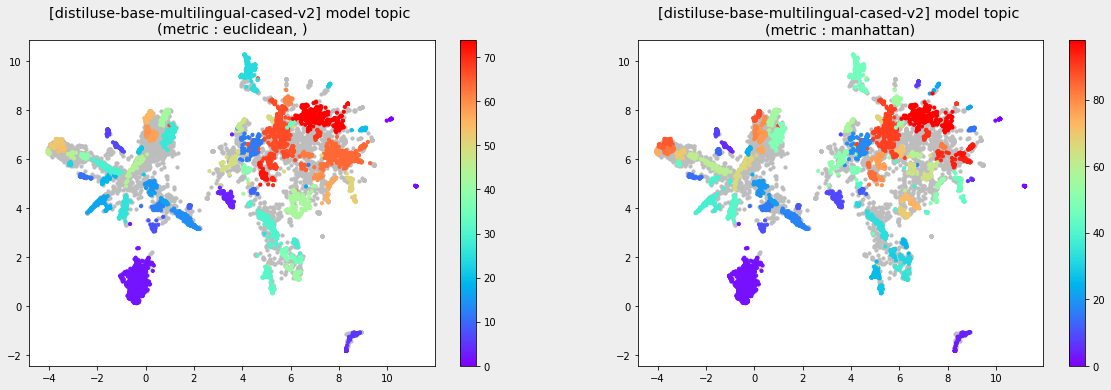

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

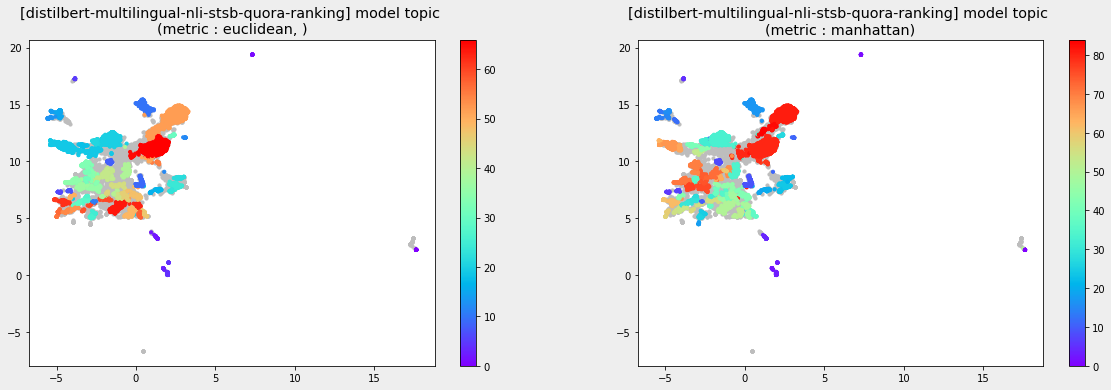

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

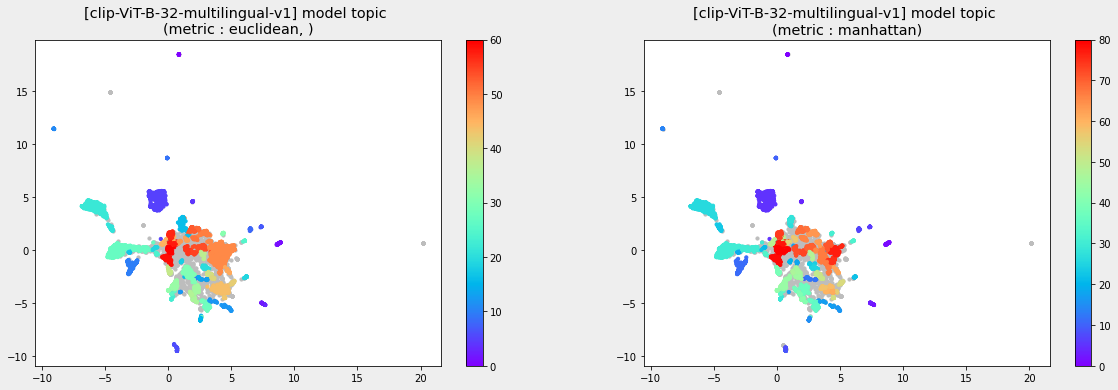

Batches:   0%|          | 0/284 [00:00<?, ?it/s]

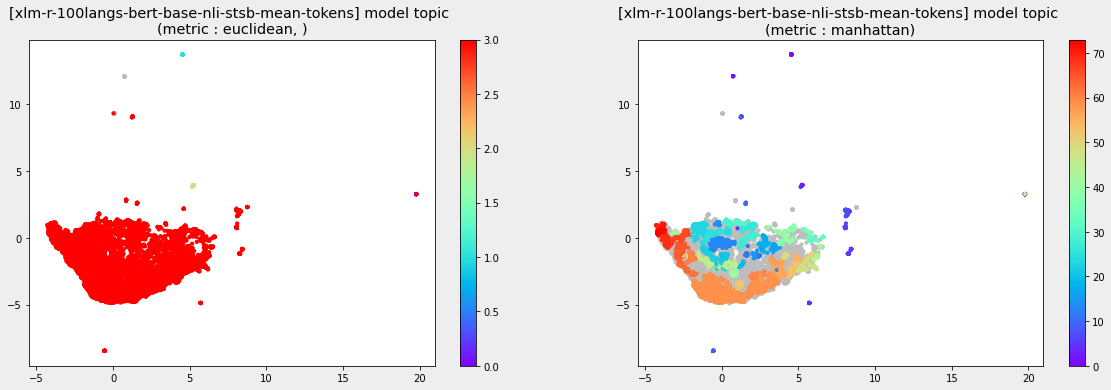

In [ ]:
from sentence_transformers import SentenceTransformer

model_list = [
              # 'distilbert-base-nli-stsb-mean-tokens',
              'msmarco-distilbert-dot-v5',
              # 'paraphrase-albert-small-v2',
              # 'distilbert-multilingual-nli-stsb-quora-ranking',
              # 'quora-distilbert-multilingual',
              'distilbert-base-nli-stsb-quora-ranking',

              'paraphrase-multilingual-MiniLM-L12-v2',
              'distiluse-base-multilingual-cased-v2',
              'distilbert-multilingual-nli-stsb-quora-ranking',
              'clip-ViT-B-32-multilingual-v1',
              # 'quora-distilbert-multilingual',
              'xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
              ]

print('대상제품 : {} '.format(df.product_nm.unique()[0]))

for model_ in model_list:
    model = SentenceTransformer(model_)
    embeddings = model.encode(doc, show_progress_bar=True)

    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

    cluster1 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)
    cluster2 = hdbscan.HDBSCAN(min_cluster_size=12, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels1'] = cluster1.labels_
    result['labels2'] = cluster2.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')

    plt.subplot(1,2,1)
    outliers = result.loc[result.labels1 == -1, :]
    clustered = result.loc[result.labels1 != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels1, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : euclidean, )'.format(model_),fontsize='x-large')
    plt.colorbar()

    plt.subplot(1,2,2)
    outliers2 = result.loc[result.labels2 == -1, :]
    clustered2 = result.loc[result.labels2 != -1, :]
    plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=10)
    plt.scatter(clustered2.x, clustered2.y, c=clustered2.labels2, s=10, cmap='rainbow')
    plt.title('[{}] model topic \n(metric : manhattan)'.format(model_),fontsize='x-large')
    plt.colorbar()
    plt.show()

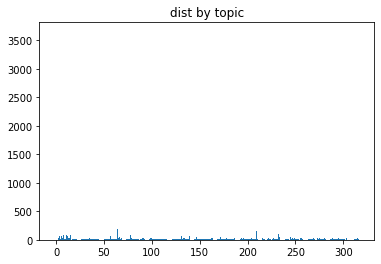

In [ ]:
plt.bar(result.labels2.value_counts().index, result.labels2.value_counts())
plt.title('dist by topic')
plt.show()

In [ ]:
result.labels1.value_counts()

 3     2754
-1     1574
 36    1492
 42     701
 57     201
       ... 
 16      16
 54      16
 40      15
 23      15
 49      15
Name: labels1, Length: 69, dtype: int64

In [ ]:
result['REVIEW'] = doc
result['MODEL'] = 'clip-ViT-B-32-multilingual-v1'

In [ ]:
excel_name ='review_data_sort_topic.xlsx'
writer = pd.ExcelWriter(excel_name)
result.to_excel(writer, 'Sheet1')
writer.save()

#### B.결과 저장

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
from sentence_transformers import SentenceTransformer

def topic_modeling(text_list, model_name):
    # 임베딩
    model = SentenceTransformer(model_name)
    embeddings = model.encode(text_list, show_progress_bar=True)

    # 차원축소
    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

    # 클러스터링
    cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

    # 결과 정리
    result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    result['REVIEW'] = text_list
    result['MODEL'] = model_name

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 6), facecolor='#eeeeee')
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
    plt.title('[{}] model topic \n(metric : euclidean)'.format(model_name),fontsize='x-large')
    plt.colorbar()
    plt.show()

    return result

In [ ]:
Topic_Model_1 = topic_modeling(doc, 'msmarco-distilbert-dot-v5')

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
Topic_Model_2 = topic_modeling(doc, 'distiluse-base-multilingual-cased-v2')

In [ ]:
Topic_Model_3 = topic_modeling(doc, 'distilbert-base-nli-stsb-quora-ranking')

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
Topic_Model_4 = topic_modeling(doc, 'distilbert-multilingual-nli-stsb-quora-ranking')

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
excel_name ='review_data_sort_topic.xlsx'
writer = pd.ExcelWriter(excel_name)
Topic_Model_1.to_excel(writer, 'Sheet1')
Topic_Model_2.to_excel(writer, 'Sheet2')
Topic_Model_3.to_excel(writer, 'Sheet3')
Topic_Model_4.to_excel(writer, 'Sheet4')
writer.save()

In [ ]:
excel_name ='review_data_sort_topic.xlsx'
writer = pd.ExcelWriter(excel_name)
docs_df.to_excel(writer, 'Sheet1')
writer.save()
# writer.close() #진행시, 다운로드 오류가 발생함

AttributeError: ignored

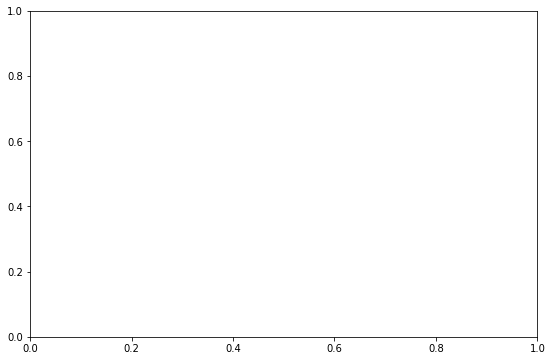

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 6))

plt.subplot(1,2,1)
outliers = result.loc[result.labels1 == -1, :]
clustered = result.loc[result.labels1 != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels1, s=10, cmap='hsv_r')
plt.title('topic dist (metric : euclidean)',fontsize='x-large')
plt.colorbar()

plt.subplot(1,2,2)
outliers2 = result.loc[result.labels2 == -1, :]
clustered2 = result.loc[result.labels2 != -1, :]
plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=10)
plt.scatter(clustered2.x, clustered2.y, c=clustered2.labels2, s=10, cmap='hsv_r')
plt.title('topic dist (metric : manhattan)',fontsize='x-large')
plt.colorbar()

plt.show()

In [ ]:
docs_df = pd.DataFrame(doc, columns=["Doc"])
docs_df['Topic'] = cluster2.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
4,4,192
16,16,149
0,0,147
3,3,145
13,13,113
2,2,108
7,7,106
5,5,105
6,6,104
9,9,88


#### C.Topic Reduction


In [ ]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(df)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Topic,Size
9,8,747
3,2,192
5,4,161
8,7,149
0,-1,147
4,3,147
2,1,145
6,5,124
7,6,113
1,0,108


In [ ]:
# top_n_words[2][:10]

In [ ]:
docs_df2 = pd.concat([docs_df,result], axis=1)

In [ ]:
docs_df2.tail()

,Doc,Topic,Doc_ID,x,y,x,y,labels1,labels2
2028,가격 대비 만족 하다,5,2028,36.207829,0.667521,36.207829,0.667521,10,3
2029,사은품 감사 하다,5,2029,36.151630,0.723601,36.151630,0.723601,10,3
2030,라이브 방송 좋다,5,2030,36.176491,0.698771,36.176491,0.698771,10,3
2031,좋다 가격 훌륭하다,5,2031,36.153435,0.721736,36.153435,0.721736,10,3
2032,가격 대비 괜찮다,5,2032,36.164646,0.710615,36.164646,0.710615,10,3


ValueError: ignored

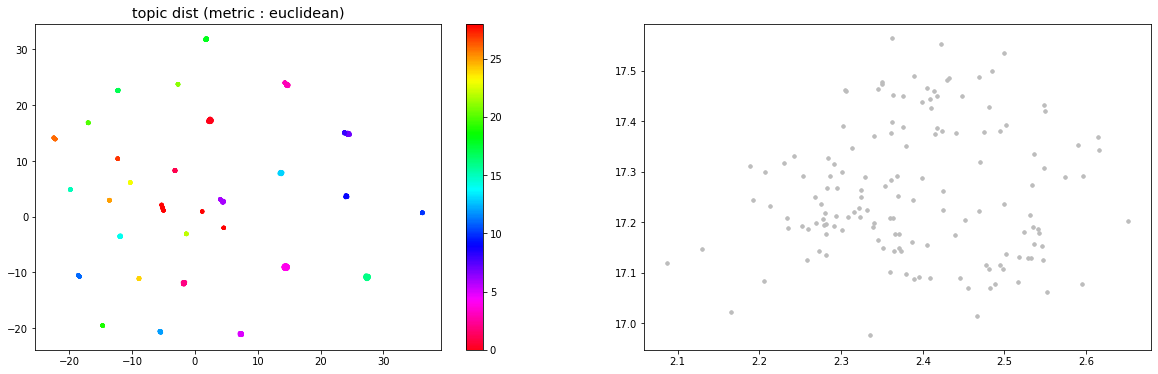

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 6))

plt.subplot(1,2,1)
outliers = result.loc[result.labels1 == -1, :]
clustered = result.loc[result.labels1 != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels1, s=10, cmap='hsv_r')
plt.title('topic dist (metric : euclidean)',fontsize='x-large')
plt.colorbar()

plt.subplot(1,2,2)
outliers2 = docs_df2.loc[docs_df2.Topic == -1, :]
clustered2 = docs_df2.loc[docs_df2.Topic != -1, :]
plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=10)
plt.scatter(clustered2.x, clustered2.y, c=clustered2.Topic, s=10, cmap='hsv_r')
plt.title('topic dist (metric : euclidean, reduce)',fontsize='x-large')
plt.colorbar()

plt.show()

In [ ]:
docs_df = pd.DataFrame(doc, columns=["Doc"])
docs_df['Topic'] = cluster1.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df['x'] = list(result['x'])
docs_df['y'] = list(result['y'])

In [ ]:
excel_name ='review_topic_modeling.xlsx'
writer = pd.ExcelWriter(excel_name)
docs_df.to_excel(writer, '1dsa')
result.to_excel(writer, '2dsa')
writer.save()